In [27]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
from keras.models import Model
from keras.layers import ELU, PReLU, LeakyReLU
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle

In [28]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

In [29]:
def unet(sz = (256, 256, 3)):
  x = Input(sz)
  inputs = x
  
  #down sampling 
  f = 8
  layers = []
  
  for i in range(0, 6):
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    layers.append(x)
    x = MaxPooling2D() (x)
    f = f*2
  ff2 = 64 
  
  #bottleneck 
  j = len(layers) - 1
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1 
  
  #upsampling 
  for i in range(0, 5):
    ff2 = ff2//2
    f = f // 2 
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1 
    
  
  #classification 
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  outputs = Conv2D(1, 1, activation='sigmoid') (x)
  
  #model creation 
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [mean_iou])
  
  return model

In [30]:
model = unet()

In [31]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

# inheritance for training process plot 
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))
        
        #choose a random test image and preprocess
        path = np.random.choice(test_files)
        raw = Image.open(f'images/{path}')
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]
        
        #predict the mask 
        pred = model.predict(np.expand_dims(raw, 0))
        
        #mask post-processing 
        msk  = pred.squeeze()
        msk = np.stack((msk,)*3, axis=-1)
        msk[msk >= 0.5] = 1 
        msk[msk < 0.5] = 0 
        
        #show the mask and the segmented image 
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

In [32]:
import os
from glob import glob
from PIL import Image
import numpy as np

# Base path of dataset
base_path = "FloodNet-Supervised_v1.0"

# Load file paths directly from folders
train_images = sorted(glob(os.path.join(base_path, "train", "train-org-img", "*.jpg")))
train_masks  = sorted(glob(os.path.join(base_path, "train", "train-label-img", "*.png")))

val_images = sorted(glob(os.path.join(base_path, "val", "val-org-img", "*.jpg")))
val_masks  = sorted(glob(os.path.join(base_path, "val", "val-label-img", "*.png")))

test_images = sorted(glob(os.path.join(base_path, "test", "test-org-img", "*.jpg")))
test_masks  = sorted(glob(os.path.join(base_path, "test", "test-label-img", "*.png")))


In [33]:
from PIL import Image
import numpy as np

mask = Image.open("FloodNet-Supervised_v1.0/test/test-label-img/6342_lab.png")
mask_np = np.array(mask)
print("Mask shape:", mask_np.shape)
print("Unique pixel values:", np.unique(mask_np))


Mask shape: (3000, 4000)
Unique pixel values: [4 5 9]


In [34]:
def supervised_generator(image_files, mask_files, batch_size=8, size=(256, 256)):
    # Define flood label values (adjust if needed)
    flood_labels = [1, 3, 5]  # Use [1, 3] if you want to exclude natural water

    while True:
        idx = np.random.choice(len(image_files), batch_size)
        batch_x, batch_y = [], []

        for i in idx:
            img = Image.open(image_files[i]).resize(size)
            mask = Image.open(mask_files[i]).resize(size)

            img = np.array(img)
            mask = np.array(mask)

            # Convert multi-class mask to binary mask (1 = flood, 0 = not flood)
            binary_mask = np.isin(mask, flood_labels).astype(np.uint8)
            binary_mask = np.expand_dims(binary_mask, axis=-1)

            # Normalize image
            if img.ndim == 2:
                img = np.stack([img]*3, axis=-1)
            else:
                img = img[:, :, :3]
            img = img / 255.0

            batch_x.append(img)
            batch_y.append(binary_mask)

        yield np.array(batch_x), np.array(batch_y)


# Define generators
train_gen = supervised_generator(train_images, train_masks)
val_gen = supervised_generator(val_images, val_masks)
test_gen = supervised_generator(test_images, test_masks)


In [35]:
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3)
]

history = model.fit(train_gen, validation_data=val_gen, steps_per_epoch=100, validation_steps=20, epochs=5, callbacks=callbacks)


Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 298s 3s/step - accuracy: 0.8307 - loss: 0.6308 - val_accuracy: 0.8385 - val_loss: 0.4731 - learning_rate: 1.0000e-04
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 283s 3s/step - accuracy: 0.8618 - loss: 0.4255 - val_accuracy: 0.8452 - val_loss: 0.4250 - learning_rate: 1.0000e-04
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 288s 3s/step - accuracy: 0.8601 - loss: 0.3676 - val_accuracy: 0.8306 - val_loss: 0.3901 - learning_rate: 1.0000e-04
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 298s 3s/step - accuracy: 0.8558 - loss: 0.3173 - val_accuracy: 0.8551 - val_loss: 0.3254 - learning_rate: 1.0000e-04
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 276s 3s/step - accuracy: 0.8446 - loss: 0.3220 - val_accuracy: 0.8642 - val_loss: 0.3162 - learning_rate: 1.0000e-04


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


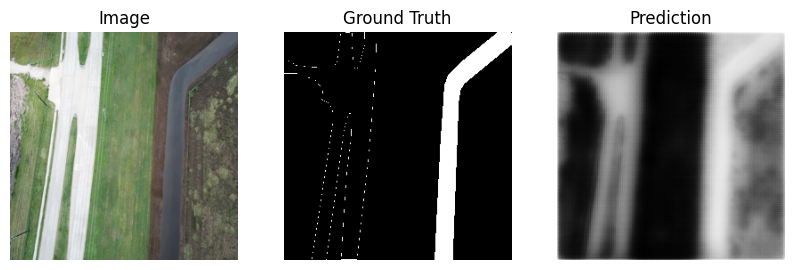

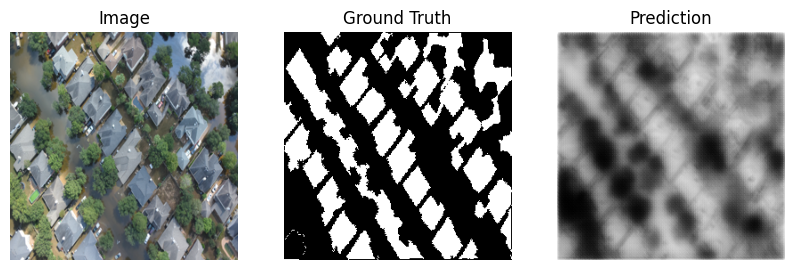

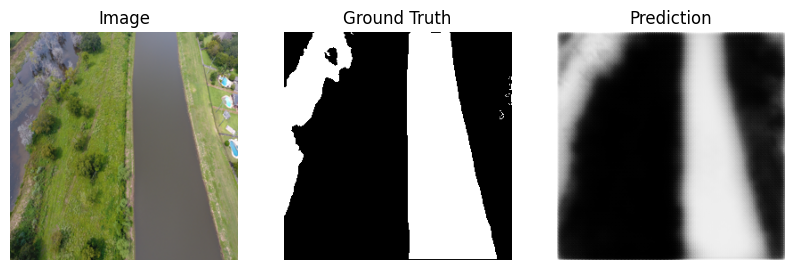

In [42]:
import matplotlib.pyplot as plt

x_sample, y_sample = next(val_gen)
pred = model.predict(x_sample)

for i in range(3):
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 3, 1)
    plt.imshow(x_sample[i])
    plt.title("Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(y_sample[i].squeeze(), cmap='gray')
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred[i].squeeze(), cmap='gray')
    plt.title("Prediction")
    plt.axis('off')
    plt.show()
